In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import os


# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

motion_transform_train = transforms.Compose([
                                    # transforms.Resize((256, 256)),
                                    # transforms.RandomHorizontalFlip(),
                                    # transforms.ColorJitter(hue=.2, saturation=.2, contrast=.2),
                                    # transforms.RandomRotation(20, interpolation=Image.BILINEAR),
                                    # transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    normalize,
                                ])

content_transform_train = transforms.Compose([
                                    transforms.RandomResizedCrop(size=(160,240)),
                                    # transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    # transforms.ColorJitter(hue=.2, saturation=.2, contrast=.2),
#                                     transforms.RandomRotation(20, interpolation=Image.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    normalize,
                                ])



class CompDataset(Dataset):
    def __init__(self, data_dir, num_frames=22, motion_transform=motion_transform_train, content_transform=content_transform_train):
        self.data_dir = data_dir
        self.motion_transform = motion_transform
        self.content_transform = content_transform
        self.num_frames = num_frames
        self.video_list = []

        self.count = 0
        for vid_dir in os.listdir(self.data_dir):
            self.video_list.append(self.data_dir +"/"+vid_dir)
            self.count +=1

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        
        video_dir = self.video_list[idx]
        frame_list = []
        frame_list_aug = []
        
        for i in range(self.num_frames):
            image = read_image(video_dir + "/" + "image_"+str(i)+".png")
            image = image/255.0
            image_aug= None
            
            if self.motion_transform:
                image = self.motion_transform(image)
            
            if self.content_transform:
                image_aug = self.content_transform(image)
            
            frame_list.append(image)
            frame_list_aug.append(image_aug)

        label = -1
        
        
        if os.path.isfile(video_dir+"/mask.npy"):
            try:
                label = np.load(video_dir+"/mask.npy")
            except:
                return None, None, None
        

        return frame_list, frame_list_aug, label

In [4]:
unlabeled_data = CompDataset("/dataset/dataset/unlabeled")
labeled_data = CompDataset("/dataset/dataset/train")
val_data = CompDataset("/dataset/dataset/val")


train_dataloader = DataLoader(unlabeled_data, batch_size=3, shuffle=True)
downstream_dataloader = DataLoader(labeled_data, batch_size=3, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True)

/ext3/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


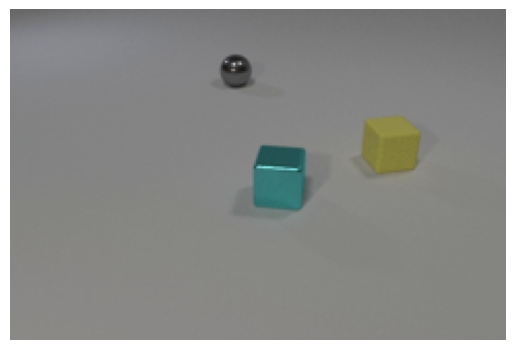

In [5]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0).numpy())
    plt.title(title)
    plt.axis('off')

show_normalized_image(unlabeled_data[10][0][0])

In [6]:
def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """

    B, C, H, W = x.size()
    # mesh grid 
    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float().to(device)
    
    if torch.is_tensor(flo): 
        vgrid = torch.autograd.Variable(grid) + flo
    else:
        vgrid = torch.autograd.Variable(grid)

    # scale grid to [-1,1] 
    vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
    vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

    vgrid = vgrid.permute(0,2,3,1)        
    output = nn.functional.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size())).to(device)
    mask = nn.functional.grid_sample(mask, vgrid)

    # if W==128:
      # np.save('mask.npy', mask.cpu().data.numpy())
      # np.save('warp.npy', output.cpu().data.numpy())

    mask[mask<0.9999] = 0
    mask[mask>0] = 1
    return output*mask

In [7]:
class FEA(nn.Module):
    def __init__ (self, in_features, out_features):
        super().__init__()
        self.cnn = nn.Conv2d(in_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn = nn.BatchNorm2d(out_features)
        self.relu = nn.ReLU()
        self.maxPool = nn.MaxPool2d(2)
        
        self.cnn2 = nn.Conv2d(out_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(out_features)
        self.relu2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(2)

    def forward(self, X_tnext, X_hat_tnext, f_tprev_t):
        correlation = self.corr4D(X_tnext, X_hat_tnext)
        batch_size, out_channels, ht, wd = X_tnext.shape
#         mat_mul = torch.matmul(correlation.view(batch_size, 1, ht*wd, ht*wd), X_tnext.view(batch_size, ht*wd, out_channels, 1))
#         print(correlation.shape)
        mat_mul = torch.matmul(correlation, X_tnext.view(batch_size, out_channels, ht*wd, 1))
        mat_mul = mat_mul.view(batch_size, out_channels, ht, wd)
        x = self.maxPool(self.relu(self.bn(self.cnn(mat_mul))))
#         x = self.maxPool2(self.relu2(self.bn2(self.cnn2(x))))
        x = self.upsample(x)
        x += 0.2*f_tprev_t
        x.requires_grad
        return x
    
    @staticmethod
    def corr4D(X_tnext, X_hat_tnext):
        batch, dim, ht, wd = X_tnext.shape
        X_tnext = X_tnext.view(batch, dim, ht*wd)
        X_hat_tnext = X_hat_tnext.view(batch, dim, ht*wd) 

        corr = torch.matmul(X_tnext.transpose(1,2), X_hat_tnext)
#         corr = corr.view(batch, ht, wd, 1, ht, wd)
        corr = corr.view(batch, 1, ht*wd, ht*wd)
        corr = corr/torch.sqrt(torch.tensor(dim).float())
        return corr
    
    @staticmethod
    def upsample(flow, scale = 2, mode='bilinear'):
        new_size = (scale * flow.shape[2], scale * flow.shape[3])
        return  scale * F.interpolate(flow, size=new_size, mode=mode, align_corners=True)

In [8]:
class Encoder(nn.Module):
    def __init__ (self, in_features, out_features):
        super().__init__()
        self.cnn = nn.Conv2d(in_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn = nn.BatchNorm2d(out_features)
        self.maxPool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        
        self.cnn2 = nn.Conv2d(out_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(out_features)
        self.maxPool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        
        self.cnn3 = nn.Conv2d(out_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(out_features)
        self.maxPool3 = nn.MaxPool2d(2)
        self.relu3 = nn.ReLU()

    def forward(self, I):
        x = self.maxPool(self.relu(self.bn(self.cnn(I))))
        x = self.maxPool2(self.relu2(self.bn2(self.cnn2(x))))
        x = self.maxPool3(self.relu3(self.bn3(self.cnn3(x))))
        return x

In [9]:
class MCJepa(nn.Module):
    def __init__(self, numLayers, in_features, out_features, out_features_fea):
        super().__init__()
        self.numLayers = numLayers;
        self.enc1 = nn.ModuleList([Encoder(in_features, out_features) for i in range(numLayers)])
        # self.enc2 = [Encoder(in_features, out_features) for i in range(numLayers)]
        self.fea = nn.ModuleList([FEA(out_features, out_features_fea) for i in range(numLayers)])
        self.f_tprev_t = 0.0 # TODO: this has to be a tensor
        self.f_tnext_t = 0.0 # TODO: this has to be a tensor
        
        # content

#         self.deconv = nn.Sequential(
#             nn.ConvTranspose2d(out_features*numLayers, out_features, kernel_size=(2,2), stride=(2,2)),
#             nn.BatchNorm2d(out_features),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(out_features, out_features, kernel_size=(2,2), stride=(2,2)),
#             nn.BatchNorm2d(out_features),
#             nn.ReLU(inplace=True),
#         )
        
        self.expander_in_features = self.numLayers*out_features*20*30
        
        self.expander = nn.Sequential(
            nn.Linear(self.expander_in_features,self.expander_in_features*4)
        )

    def reset_flows(self):
        self.f_tprev_t = 0.0
        self.f_tnext_t = 0.0 


    def forward(self, I_t, I_tnext, I_tcrop):
        X_hat_tnext = []
        X_hat_t = []
        X_t = []
        X_tnext = []
        f_t_tnext = []
        f_tnext_t = []

        
        # motion component

        for i in range(self.numLayers): # Feature extracting layer
            X_t.append(self.enc1[i](I_t))
            X_tnext.append(self.enc1[i](I_tnext))

        for i in range(self.numLayers): # Finding the flow t -> t + 1
            if i == 0:
                f_t_tnext.append(self.fea[i](X_tnext[i], X_t[0], self.f_tprev_t))
            else:
                X_hat_tnext.append(warp(X_t[i], f_t_tnext[i-1]))
                f_t_tnext.append(self.fea[i](X_tnext[i], X_hat_tnext[i-1], f_t_tnext[i-1]))

        self.f_tprev_t = torch.detach(f_t_tnext[-1]) # Remembering the flow info across frames
        
        I_hat_tnext = warp(I_t, FEA.upsample(f_t_tnext[-1], 8)) # Predicting future frame

        for i in range(self.numLayers): # Finding the flow t + 1 -> t
            if i == 0:
                f_tnext_t.append(self.fea[i](X_t[i], X_tnext[0], self.f_tnext_t))
            else:
                X_hat_t.append(warp(X_tnext[i], f_tnext_t[i-1]))
                f_tnext_t.append(self.fea[i](X_t[i], X_hat_t[i-1], f_tnext_t[i-1]))

        self.f_tnext_t = torch.detach(f_tnext_t[-1]) # Remembering the flow info across backward frames

        I_hat_t = warp(I_tnext, FEA.upsample(f_tnext_t[-1], 8)) # Predicting past frame
        
        # content component
        
        X_tconcat = X_t[0]
        X_tcrop = self.enc1[0](I_tcrop)

        for i in range(1, self.numLayers): # Feature extracting layer
            X_tconcat = torch.concat((X_tconcat,X_t[i]),dim=1)
            X_tcrop = torch.concat((X_tcrop,self.enc1[i](I_tcrop)),dim=1)
            

        X_tconcat_shape = X_tconcat.shape
        X_tconcat_flattened = X_tconcat.view(X_tconcat.shape[0],-1)
        X_tcrop_flattened = X_tcrop.view(X_tcrop.shape[0],-1)
        
        Y1 = self.expander(X_tconcat_flattened)
        Y2 = self.expander(X_tcrop_flattened)
        
        Y1 = Y1.view(X_tconcat_shape[0], X_tconcat_shape[1], 2*X_tconcat_shape[2], 2*X_tconcat_shape[3])
        Y2 = Y2.view(X_tconcat_shape[0], X_tconcat_shape[1], 2*X_tconcat_shape[2], 2*X_tconcat_shape[3])
        
#         Y1 = self.deconv(X_tcrop)
#         Y2 = self.deconv(X_tconcat)
        
#         Y1 = X_tcrop
#         Y2 = X_tconcat

#         print(Y1.shape)
        
        return X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext, Y1, Y2, X_tcrop, X_tconcat


In [10]:
def off_diagonal(M):
    res = M.clone()
    res.diagonal(dim1=-1, dim2=-2).zero_()
    return res

def vc_reg(X_t, X_tnext, lm, mu, nu):
    N = X_t.shape[0]
    C = X_t.shape[1]
    H = X_t.shape[2]
    W = X_t.shape[3] 
    D = C + H + W 
    mse_loss = nn.MSELoss()
    sim_loss = mse_loss(X_t, X_tnext)
    
    std_z_a = torch.sqrt(X_t.var(dim=0) + 1e-04)
    std_z_b = torch.sqrt(X_tnext.var(dim=0) + 1e-04)
    std_loss = torch.mean(F.relu(1-std_z_a)) + torch.mean(F.relu(1-std_z_b))

    X_t = X_t - X_t.mean(dim=0)
    X_tnext = X_tnext - X_tnext.mean(dim=0)
    cov_z_a = torch.matmul(X_t.view(N, C, W, H), X_t)/ (N-1)
    cov_z_b = torch.matmul(X_tnext.view(N, C, W, H), X_tnext)/ (N-1)
    conv_loss = (off_diagonal(cov_z_a).pow_(2).sum()/D) + (off_diagonal(cov_z_b).pow_(2).sum()/D) 
        
    loss = lm*sim_loss + mu*std_loss + nu*conv_loss
    return loss

def cycle_loss_fn(f_t_tnext, f_tnext_t, X_t, X_tnext, lambda_a, lambda_b):
    loss_cycle_A = torch.tensor(0.0).to(device)
    loss_cycle_B = torch.tensor(0.0).to(device)
    for i in range(1, len(X_t)):
        loss_cycle_A += F.l1_loss(warp(X_t[i], f_t_tnext[i]), X_tnext[i]) * lambda_a
        loss_cycle_B += F.l1_loss(warp(X_tnext[i], f_tnext_t[i]), X_t[i]) * lambda_b

    return loss_cycle_A + loss_cycle_B

In [11]:
def MCJepa_criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext, img1, img2, Y1, Y2, X_tcrop, X_tconcat, lm, mu, nu, lambda_a, lambda_b):
  
    mse_loss = nn.MSELoss()    
    rec_loss = nn.MSELoss()
    reg_loss = nn.MSELoss()
    
    regress_loss_forward = torch.tensor(0.0).to(device)
    regress_loss_backward = torch.tensor(0.0).to(device)
    for i in range(len(X_hat_tnext)):
        regress_loss_forward += torch.sqrt(reg_loss(X_hat_tnext[i], X_tnext[i+1]))
        regress_loss_backward += torch.sqrt(reg_loss(X_hat_t[i], X_t[i+1]))
    

    reconst_loss_forward = rec_loss(I_hat_tnext, img2) 
    reconst_loss_backward = rec_loss(I_hat_t, img1) 
    vc_reg_loss = torch.tensor(0.0).to(device)
    
    for i in range(len(X_t)):
        vc_reg_loss += vc_reg(X_t[i], X_tnext[i], lm, mu, nu)

    cycle_loss = cycle_loss_fn(f_t_tnext, f_tnext_t, X_t, X_tnext, lambda_a, lambda_b)


    # content 

    vc_content_loss = vc_reg(X_tcrop, X_tconcat, lm, mu, nu)
    vc_content_expander_loss = vc_reg(Y1, Y2, lm, mu, nu)

    content_regress_loss = torch.sqrt(reg_loss(Y1,Y2))
    
    
#     print("Regress Loss Forward: ", regress_loss_forward)
#     print("Regress Loss Backward: ", regress_loss_backward)
#     print("Reconst Loss Forward: ", reconst_loss_forward)
#     print("Reconst Loss Backward: ", reconst_loss_backward)
#     print("VicReg Motion Loss: ", vc_reg_loss)
#     print("Cycle Loss: ", cycle_loss)
#     print("VicReg Content Loss: ", vc_content_loss)
#     print("VicReg Content Expander Loss: ", vc_content_expander_loss)
#     print("Content Regress Loss: ", content_regress_loss)
    

    return regress_loss_forward + regress_loss_backward + reconst_loss_forward + reconst_loss_backward + vc_reg_loss + cycle_loss + vc_content_loss + vc_content_expander_loss + content_regress_loss



In [12]:
from tqdm import tqdm

def train_MCJepa(model, epochs, dataloader, criterion, optimizer):
    model.train()

    train_losses = []

    best_loss = float("inf")
    best_model = model.state_dict()

    for _ in range(epochs):
        total_train_loss = 0.0
        total_train_correct = 0.0
        
        pbar = tqdm(dataloader, leave=False)

        for j,batch in enumerate(pbar):
            
            if j == 4333: 
                break

            frame_list, frame_list_aug, label = batch[0], batch[1], batch[2]
            total_train_loss = 0.0
            model.reset_flows()
            
            for i in range(len(frame_list) - 1):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+1].to(device)
                img3 = frame_list_aug[i].to(device)
                
                

                X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext, Y1, Y2, X_tcrop,\
                                            X_tconcat = model(img1, img2, img3)

                loss = criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                                f_tnext_t, I_hat_t, I_hat_tnext, img1, img2,\
                                 Y1, Y2, X_tcrop, X_tconcat, lm, mu, nu, lambda_a, lambda_b)
            
                total_train_loss += loss.item()
            
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1)})

            if total_train_loss/(len(frame_list)-1) < best_loss:
                best_loss = total_train_loss/(len(frame_list)-1)
                best_model = model.state_dict()
                
                if j%15 == 0:
                    torch.save(best_model,"best_model.pth")
                    pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'Saved model with loss': best_loss})
            
            
        pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'Saved model at j': j})
        torch.save(model.state_dict(), "model.pth")
            


        torch.save(best_model,"best_model_.pth")

In [13]:
# Constants to figure out later
numLayers = 5
in_features = 3 
out_features = 4
out_features_fea = 2
lm, mu, nu, lambda_a, lambda_b = 0.02, 0.02, 0.01, 1, 1


MCJepa_model = MCJepa(numLayers, in_features, out_features, out_features_fea).to(device)
optimizer = optim.Adam(MCJepa_model.parameters(), lr = 0.0001)

In [14]:
train_MCJepa(MCJepa_model, 1, train_dataloader, MCJepa_criterion, optimizer) # Training the MC JEPA

  0%|          | 0/4334 [00:00<?, ?it/s]/ext3/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Regress Loss Forward:  tensor(4.4559, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(4.4568, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0895, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0907, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(107.1276, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(3.2655, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(93.9295, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(14.6681, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.7535, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(4.5276, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(4.5286, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0947, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0959

  0%|          | 0/4334 [00:04<?, ?it/s, Per frame Loss=186]

Regress Loss Forward:  tensor(4.2266, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(4.2329, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1283, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1242, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(78.3374, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(3.4658, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(64.8875, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(6.4532, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.6273, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(4.1854, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(4.2567, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1270, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1265, 

  0%|          | 1/4334 [00:35<42:17:20, 35.14s/it, Per frame Loss=186, Saved model with loss=186]

Regress Loss Forward:  tensor(4.2892, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(4.2871, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0788, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0794, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(95.0169, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(3.1918, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(74.6222, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(11.5740, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.7211, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(4.2522, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(4.2348, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0809, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0784,

  0%|          | 2/4334 [00:38<19:47:39, 16.45s/it, Per frame Loss=174]                           

Regress Loss Forward:  tensor(3.9336, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(3.9625, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1048, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0956, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(66.8069, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(3.2797, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(53.2611, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(5.8985, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.6020, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(3.9627, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(3.9467, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0413, 

  0%|          | 3/4334 [00:42<12:40:31, 10.54s/it, Per frame Loss=124]

Regress Loss Forward:  tensor(3.7359, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(3.7350, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0915, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0843, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(47.9851, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(3.0882, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(39.1531, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(2.9177, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.5262, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(3.5288, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(3.5153, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0496, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0502, 

  0%|          | 4/4334 [00:45<9:15:25,  7.70s/it, Per frame Loss=73.7] 

Regress Loss Forward:  tensor(3.3707, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(3.4913, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0828, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0865, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(28.1715, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.7690, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(22.6338, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(2.9100, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.5289, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(3.2119, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(3.2068, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0358, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0359, 

  0%|          | 5/4334 [00:48<7:23:26,  6.15s/it, Per frame Loss=61.6]

Regress Loss Forward:  tensor(3.1898, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(3.2205, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0756, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0790, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(21.6387, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.7166, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(30.0674, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(1.6605, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.4602, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(3.2509, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(3.2613, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0511, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0504, 

  0%|          | 6/4334 [00:52<6:16:16,  5.22s/it, Per frame Loss=50.7]

Regress Loss Forward:  tensor(3.0772, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(3.0523, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0888, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0854, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(12.3522, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.8498, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(17.8369, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(1.7245, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.4455, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(2.9900, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(3.0013, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0557, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0549, 

  0%|          | 7/4334 [00:55<5:32:20,  4.61s/it, Per frame Loss=36.4]

Regress Loss Forward:  tensor(2.8417, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.8672, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1091, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1040, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(9.5482, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.5674, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(12.5810, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.8491, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.3713, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(2.7995, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.7764, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0672, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0716, d

  0%|          | 8/4334 [00:58<5:03:08,  4.20s/it, Per frame Loss=26.4]

Regress Loss Forward:  tensor(2.7619, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.7638, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1053, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1114, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(5.5691, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.8329, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(5.1046, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.5108, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.3404, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(2.5879, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.6207, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0731, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0729, de

  0%|          | 9/4334 [01:02<4:46:04,  3.97s/it, Per frame Loss=19]  

Regress Loss Forward:  tensor(2.7517, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.6429, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1322, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1288, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(4.9797, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.3455, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(5.3301, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.3440, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(2.6984, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.7490, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1272, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1207, de

  0%|          | 10/4334 [01:05<4:32:32,  3.78s/it, Per frame Loss=19]

Regress Loss Forward:  tensor(2.5270, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.5082, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1036, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1007, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(3.9715, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.5105, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(4.7132, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.2942, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2849, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(2.4184, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.4095, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0615, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0608, de

  0%|          | 11/4334 [01:08<4:22:35,  3.64s/it, Per frame Loss=16.7]

Regress Loss Forward:  tensor(2.3807, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.4144, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1112, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1082, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(2.7330, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.3804, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(6.3256, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.3296, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2880, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(2.3129, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.3097, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0729, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0723, de

  0%|          | 12/4334 [01:12<4:17:30,  3.57s/it, Per frame Loss=14.4]

Regress Loss Forward:  tensor(2.3113, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.3258, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1046, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0987, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(2.8001, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.3779, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(3.3407, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.2957, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2843, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(2.4780, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.4749, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0660, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0639, de

  0%|          | 13/4334 [01:15<4:12:27,  3.51s/it, Per frame Loss=17.7]

Regress Loss Forward:  tensor(2.2802, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.2746, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0924, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0985, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(2.4890, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.3519, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.9178, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.2229, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2637, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(2.1435, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.1041, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0932, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0952, de

  0%|          | 14/4334 [01:19<4:09:41,  3.47s/it, Per frame Loss=12.5]

Regress Loss Forward:  tensor(2.1834, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.1905, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1354, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1395, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(1.8281, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.2911, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(4.7021, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2408, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(2.1161, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.1169, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0950, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0937, de

  0%|          | 15/4334 [01:22<4:07:05,  3.43s/it, Per frame Loss=12.8]

Regress Loss Forward:  tensor(2.2291, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.2390, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1542, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1629, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(2.6810, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.2190, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(4.0905, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.3182, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2747, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(2.0784, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.0346, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0555, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0498, de

  0%|          | 15/4334 [01:25<4:07:05,  3.43s/it, Per frame Loss=10.4]

Regress Loss Forward:  tensor(2.0723, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.1194, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0790, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0897, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(1.4345, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.1054, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(2.0080, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.1672, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2301, device='cuda:0', grad_fn=<SqrtBackward0>)


  0%|          | 16/4334 [01:57<15:22:16, 12.82s/it, Per frame Loss=10.4, Saved model with loss=10.4]

Regress Loss Forward:  tensor(1.9590, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.9337, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0629, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0631, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.7733, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.8585, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(2.2420, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2171, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.9972, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.9877, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0733, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0760, de

  0%|          | 17/4334 [02:00<12:00:33, 10.01s/it, Per frame Loss=9.79]                            

Regress Loss Forward:  tensor(1.9969, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(2.0281, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1193, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1256, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(1.5778, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.0991, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(2.4604, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.1642, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2367, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.9987, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.9797, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0737, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0733, de

  0%|          | 18/4334 [02:03<9:36:18,  8.01s/it, Per frame Loss=9.37] 

Regress Loss Forward:  tensor(1.8401, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.8037, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0654, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0655, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.9414, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.6215, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.3508, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2246, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.8601, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.8596, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0762, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0785, de

  0%|          | 19/4334 [02:07<7:55:19,  6.61s/it, Per frame Loss=8.99]

Regress Loss Forward:  tensor(1.8676, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.8668, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1069, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1215, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(1.1321, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(2.0018, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.3531, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2304, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.8251, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.7885, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0621, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0690, de

  0%|          | 20/4334 [02:10<6:44:53,  5.63s/it, Per frame Loss=8.97]

Regress Loss Forward:  tensor(1.8587, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.8537, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0939, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0952, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.9098, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.9938, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.7573, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1977, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.7700, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.7639, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0478, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0506, de

  0%|          | 21/4334 [02:13<5:55:40,  4.95s/it, Per frame Loss=8.15]

Regress Loss Forward:  tensor(1.7417, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.7180, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0755, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0750, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.6334, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.7956, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.1028, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1964, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.6393, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.6402, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0603, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0614, de

  1%|          | 22/4334 [02:17<5:20:41,  4.46s/it, Per frame Loss=7.9] 

Regress Loss Forward:  tensor(1.7187, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.7494, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0624, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0613, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.7494, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.6544, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.3727, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.2100, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.7122, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.7243, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0676, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0732, de

  1%|          | 23/4334 [02:20<4:57:09,  4.14s/it, Per frame Loss=7.78]

Regress Loss Forward:  tensor(1.7074, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.7163, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1029, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1097, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.7983, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.8139, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.9237, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1986, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.5173, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.5251, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0573, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0582, de

  1%|          | 24/4334 [02:24<4:40:40,  3.91s/it, Per frame Loss=7.41]

Regress Loss Forward:  tensor(1.5130, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.5173, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0856, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0868, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.7707, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.6307, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(2.8109, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1852, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.5507, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.5493, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0744, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0738, de

  1%|          | 25/4334 [02:27<4:28:30,  3.74s/it, Per frame Loss=7.15]

Regress Loss Forward:  tensor(1.5625, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.5484, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1207, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1205, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.6590, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.5898, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.8712, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1798, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.6151, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.6183, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0666, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0686, de

  1%|          | 26/4334 [02:30<4:20:06,  3.62s/it, Per frame Loss=7.4] 

Regress Loss Forward:  tensor(1.5382, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.5831, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0876, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0884, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.5682, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.5725, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.3641, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1948, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.5472, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.5363, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0804, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0781, de

  1%|          | 27/4334 [02:34<4:13:40,  3.53s/it, Per frame Loss=6.82]

Regress Loss Forward:  tensor(1.5888, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.6107, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1208, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1234, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.6840, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.6987, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.9272, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1944, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.5036, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.5025, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0831, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0832, de

  1%|          | 28/4334 [02:37<4:10:16,  3.49s/it, Per frame Loss=6.7] 

Regress Loss Forward:  tensor(1.5437, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.5537, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1266, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1212, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.7474, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.4275, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1753, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.4760, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.4669, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0781, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0778, de

  1%|          | 29/4334 [02:40<4:07:00,  3.44s/it, Per frame Loss=6.29]

Regress Loss Forward:  tensor(1.4940, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.5007, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1065, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0934, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.6017, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.5982, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.6144, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1785, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.4270, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.4664, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0470, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0518, de

  1%|          | 30/4334 [02:44<4:04:45,  3.41s/it, Per frame Loss=7.3] 

Regress Loss Forward:  tensor(1.4413, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.4250, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0610, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0553, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.6045, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.4520, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.6903, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1676, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.4943, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.5024, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0822, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0808, de

  1%|          | 30/4334 [02:47<4:04:45,  3.41s/it, Per frame Loss=6.08]

Regress Loss Forward:  tensor(1.3851, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.3801, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0795, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0748, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.4111, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1565, device='cuda:0', grad_fn=<SqrtBackward0>)


  1%|          | 31/4334 [03:17<14:59:18, 12.54s/it, Per frame Loss=6.08, Saved model with loss=6.08]

Regress Loss Forward:  tensor(1.4867, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.4911, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0860, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0848, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.5272, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.4861, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.8447, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1678, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.4824, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.4923, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0871, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0807, de

  1%|          | 32/4334 [03:21<11:42:19,  9.80s/it, Per frame Loss=6.3]                             

Regress Loss Forward:  tensor(1.4188, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.4156, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0980, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0959, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.4006, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.6716, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1623, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.3675, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.3525, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0780, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0828, de

  1%|          | 33/4334 [03:24<9:24:39,  7.88s/it, Per frame Loss=5.73] 

Regress Loss Forward:  tensor(1.3641, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.3818, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1107, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1230, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.4263, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.4089, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3099, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1427, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.2521, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2595, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0631, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0637, de

  1%|          | 34/4334 [03:28<7:48:19,  6.53s/it, Per frame Loss=5.91]

Regress Loss Forward:  tensor(1.3299, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.3495, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0814, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0804, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3839, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.3835, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.5332, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1533, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.3218, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.3318, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0339, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0333, de

  1%|          | 35/4334 [03:31<6:39:44,  5.58s/it, Per frame Loss=5.46]

Regress Loss Forward:  tensor(1.2736, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2965, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0660, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0646, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3041, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.3046, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.2206, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1396, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.2905, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2469, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0777, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0768, de

  1%|          | 36/4334 [03:35<5:56:48,  4.98s/it, Per frame Loss=5.51]

Regress Loss Forward:  tensor(1.2623, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2698, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0800, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0804, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3353, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.2553, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1407, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.2793, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2762, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0667, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0694, de

  1%|          | 37/4334 [03:38<5:21:55,  4.50s/it, Per frame Loss=6.22]

Regress Loss Forward:  tensor(1.4087, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.3996, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1303, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1469, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.5322, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3805, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1507, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.2377, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2371, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0676, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0676, de

  1%|          | 38/4334 [03:41<4:57:04,  4.15s/it, Per frame Loss=5.39]

Regress Loss Forward:  tensor(1.2672, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2548, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0808, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0826, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.2909, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.4125, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1369, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.1790, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1767, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0420, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0434, de

  1%|          | 39/4334 [03:45<4:40:26,  3.92s/it, Per frame Loss=5.21]

Regress Loss Forward:  tensor(1.2332, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2436, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0817, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0900, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3010, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.2735, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1340, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.1505, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1504, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0692, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0708, de

  1%|          | 40/4334 [03:48<4:28:36,  3.75s/it, Per frame Loss=5.26]

Regress Loss Forward:  tensor(1.2825, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2781, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1020, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1092, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3617, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.4275, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.4322, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1467, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.1863, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1857, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0522, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0548, de

  1%|          | 41/4334 [03:51<4:19:58,  3.63s/it, Per frame Loss=5.13]

Regress Loss Forward:  tensor(1.2448, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2435, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0894, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0791, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3771, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.2673, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.6399, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1403, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.2599, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2578, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0555, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0560, de

  1%|          | 42/4334 [03:55<4:14:00,  3.55s/it, Per frame Loss=5.02]

Regress Loss Forward:  tensor(1.1927, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1901, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0881, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0874, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3111, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.1785, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3955, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1348, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.2020, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1761, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0645, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0642, de

  1%|          | 43/4334 [03:58<4:09:09,  3.48s/it, Per frame Loss=5.39]

Regress Loss Forward:  tensor(1.2875, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2707, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1023, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1022, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.3209, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.4794, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1497, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.1422, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1133, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0783, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0767, de

  1%|          | 44/4334 [04:01<4:06:39,  3.45s/it, Per frame Loss=5.13]

Regress Loss Forward:  tensor(1.2055, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2014, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0921, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0925, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3401, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.2939, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.7346, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1412, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.1315, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1262, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0657, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0670, de

  1%|          | 45/4334 [04:05<4:05:06,  3.43s/it, Per frame Loss=4.91]

Regress Loss Forward:  tensor(1.2161, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1918, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1150, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1025, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3742, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.2557, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(2.7162, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1299, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.1330, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1290, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0634, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0573, de

  1%|          | 46/4334 [04:08<4:02:59,  3.40s/it, Per frame Loss=4.99]

Regress Loss Forward:  tensor(1.2331, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2321, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0953, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0945, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3462, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.3017, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2867, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1333, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.0808, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0793, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0523, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0519, de

  1%|          | 47/4334 [04:12<4:03:37,  3.41s/it, Per frame Loss=4.91]

Regress Loss Forward:  tensor(1.1288, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1213, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0738, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0740, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3068, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.1148, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.5570, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1295, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.1360, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1269, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0457, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0437, de

  1%|          | 48/4334 [04:15<4:02:52,  3.40s/it, Per frame Loss=4.47]

Regress Loss Forward:  tensor(1.1499, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1437, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0744, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0605, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3252, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.0986, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3052, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1353, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.0911, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0688, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0496, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0498, de

  1%|          | 49/4334 [04:18<4:01:55,  3.39s/it, Per frame Loss=4.64]

Regress Loss Forward:  tensor(1.1591, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1525, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0930, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0941, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3724, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.1597, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1340, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.0410, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0386, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0646, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0644, de

  1%|          | 50/4334 [04:22<4:01:37,  3.38s/it, Per frame Loss=4.76]

Regress Loss Forward:  tensor(1.1183, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1258, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0749, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0813, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3085, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.1510, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.5164, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1209, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.0861, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0889, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0477, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0478, de

  1%|          | 51/4334 [04:25<4:00:45,  3.37s/it, Per frame Loss=4.82]

Regress Loss Forward:  tensor(1.0937, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1082, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0804, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0900, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2923, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.0501, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1223, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.1020, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0952, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0565, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0535, de

  1%|          | 52/4334 [04:28<3:59:41,  3.36s/it, Per frame Loss=4.6] 

Regress Loss Forward:  tensor(1.1089, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1141, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0989, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1028, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2804, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.1934, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.5796, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1417, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.2327, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2432, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0643, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0633, de

  1%|          | 53/4334 [04:32<3:59:01,  3.35s/it, Per frame Loss=4.85]

Regress Loss Forward:  tensor(1.2234, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.2285, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0970, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0966, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3576, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.1714, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.0895, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1121, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(1.0675, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0759, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0775, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0777, de

  1%|          | 54/4334 [04:35<3:59:52,  3.36s/it, Per frame Loss=4.61]

Regress Loss Forward:  tensor(1.0858, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0869, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0983, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0961, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3148, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.1246, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2754, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1195, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9644, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9618, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0566, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0544, de

  1%|▏         | 55/4334 [04:38<3:59:47,  3.36s/it, Per frame Loss=4.3] 

Regress Loss Forward:  tensor(1.0173, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0107, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0918, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0892, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3372, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.0095, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3024, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1042, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9942, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9924, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0443, de

  1%|▏         | 56/4334 [04:42<4:01:22,  3.39s/it, Per frame Loss=4.27]

Regress Loss Forward:  tensor(1.0089, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0089, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0682, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0737, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2807, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9444, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1098, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9918, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9869, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0732, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0744, de

  1%|▏         | 57/4334 [04:45<3:59:43,  3.36s/it, Per frame Loss=4.47]

Regress Loss Forward:  tensor(1.0692, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0566, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1167, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1073, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2722, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.1047, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3442, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1140, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9959, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0014, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0575, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0579, de

  1%|▏         | 58/4334 [04:49<3:59:59,  3.37s/it, Per frame Loss=4.11]

Regress Loss Forward:  tensor(0.9729, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9828, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0614, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0628, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2800, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9258, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3484, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0423, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1040, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9499, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9434, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0634, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0621, de

  1%|▏         | 59/4334 [04:52<4:01:12,  3.39s/it, Per frame Loss=3.95]

Regress Loss Forward:  tensor(1.0440, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0376, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0856, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0906, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2832, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.0411, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.7338, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1139, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9578, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9601, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0463, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0443, de

  1%|▏         | 60/4334 [04:55<4:00:42,  3.38s/it, Per frame Loss=3.96]

Regress Loss Forward:  tensor(0.9814, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9747, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0690, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0675, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2436, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9237, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1672, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1064, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9978, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9956, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0583, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0608, de

  1%|▏         | 61/4334 [04:59<4:00:46,  3.38s/it, Per frame Loss=4.31]

Regress Loss Forward:  tensor(1.0769, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0585, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1254, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1008, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2791, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.1811, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.5243, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1185, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9677, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9710, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0666, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0656, de

  1%|▏         | 62/4334 [05:02<4:00:02,  3.37s/it, Per frame Loss=4.19]

Regress Loss Forward:  tensor(1.0136, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0080, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0685, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0749, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.3038, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.0542, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2302, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1134, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9280, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9244, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0620, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0616, de

  1%|▏         | 63/4334 [05:06<3:59:57,  3.37s/it, Per frame Loss=4.05]

Regress Loss Forward:  tensor(1.0449, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0262, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1024, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0913, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2847, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.0684, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.4375, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1238, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.8827, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8834, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0541, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0559, de

  1%|▏         | 64/4334 [05:09<4:00:57,  3.39s/it, Per frame Loss=3.91]

Regress Loss Forward:  tensor(1.0113, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0274, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0951, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0970, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2860, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.0567, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1100, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9514, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9532, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0378, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0372, de

  1%|▏         | 65/4334 [05:12<4:00:26,  3.38s/it, Per frame Loss=3.98]

Regress Loss Forward:  tensor(1.0034, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.0066, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0843, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0791, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2743, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.0193, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1107, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9396, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9392, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0602, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0602, de

  2%|▏         | 66/4334 [05:16<4:00:03,  3.37s/it, Per frame Loss=4.23]

Regress Loss Forward:  tensor(1.1383, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(1.1613, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1007, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0948, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.4429, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(1.1559, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1618, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9341, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9381, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0710, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0722, de

  2%|▏         | 67/4334 [05:19<4:00:13,  3.38s/it, Per frame Loss=3.98]

Regress Loss Forward:  tensor(0.9469, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9527, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0823, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0776, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2505, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9471, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1137, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9305, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9285, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0471, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0443, de

  2%|▏         | 68/4334 [05:22<3:59:35,  3.37s/it, Per frame Loss=4.14]

Regress Loss Forward:  tensor(0.9260, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9256, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0540, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0572, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2539, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9306, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.7074, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1025, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.8933, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8880, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0703, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0710, de

  2%|▏         | 69/4334 [05:26<3:59:43,  3.37s/it, Per frame Loss=3.82]

Regress Loss Forward:  tensor(0.9095, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8996, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0936, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0988, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2462, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9250, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.7350, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1088, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.8521, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8443, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0568, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0601, de

  2%|▏         | 70/4334 [05:29<4:00:30,  3.38s/it, Per frame Loss=3.66]

Regress Loss Forward:  tensor(0.8652, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8748, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0802, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0841, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2491, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.8382, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2198, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0423, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1038, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.8393, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8436, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0500, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0496, de

  2%|▏         | 71/4334 [05:33<3:59:38,  3.37s/it, Per frame Loss=3.71]

Regress Loss Forward:  tensor(0.8992, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9325, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0887, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0884, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2458, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9373, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2187, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0953, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.9261, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9284, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0556, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0499, de

  2%|▏         | 72/4334 [05:36<3:59:11,  3.37s/it, Per frame Loss=3.88]

Regress Loss Forward:  tensor(0.9755, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9850, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1034, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0888, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2697, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9522, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2142, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1143, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.8374, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8269, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0392, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0394, de

  2%|▏         | 73/4334 [05:39<3:59:35,  3.37s/it, Per frame Loss=3.35]

Regress Loss Forward:  tensor(0.8325, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8434, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0568, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0594, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2250, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.8318, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2025, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0935, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.8094, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8123, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0767, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0772, de

  2%|▏         | 74/4334 [05:43<4:01:47,  3.41s/it, Per frame Loss=3.56]

Regress Loss Forward:  tensor(0.9044, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9110, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0843, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0910, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2357, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9158, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1639, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0968, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.8284, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8274, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0514, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0507, de

  2%|▏         | 75/4334 [05:46<4:01:52,  3.41s/it, Per frame Loss=3.52]

Regress Loss Forward:  tensor(0.8530, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8561, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0820, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0841, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2264, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.8770, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3460, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1003, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.8248, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8216, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0576, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0605, de

  2%|▏         | 75/4334 [05:50<4:01:52,  3.41s/it, Per frame Loss=3.31]

Regress Loss Forward:  tensor(0.8993, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.9119, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1029, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1069, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2287, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9606, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1941, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0929, device='cuda:0', grad_fn=<SqrtBackward0>)


  2%|▏         | 76/4334 [06:20<14:51:22, 12.56s/it, Per frame Loss=3.31, Saved model with loss=3.31]

Regress Loss Forward:  tensor(0.7997, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7974, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0569, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0566, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2248, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.7460, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3044, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1016, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.8182, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8109, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0597, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0604, de

  2%|▏         | 77/4334 [06:23<11:35:39,  9.80s/it, Per frame Loss=3.25]                            

Regress Loss Forward:  tensor(0.8684, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8664, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0920, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0910, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2461, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9440, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2091, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1020, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.7687, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7740, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0791, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0790, de

  2%|▏         | 78/4334 [06:27<9:18:14,  7.87s/it, Per frame Loss=3.56] 

Regress Loss Forward:  tensor(0.8696, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8697, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0895, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0944, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2604, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.8746, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0945, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.8507, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8379, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0585, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0594, de

  2%|▏         | 79/4334 [06:30<7:42:21,  6.52s/it, Per frame Loss=3.39]

Regress Loss Forward:  tensor(0.8504, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8492, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0706, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0702, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2350, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.8702, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1642, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0947, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.7284, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7283, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0501, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0484, de

  2%|▏         | 80/4334 [06:34<6:34:53,  5.57s/it, Per frame Loss=3.32]

Regress Loss Forward:  tensor(0.8294, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8334, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0880, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0897, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2293, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.8534, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0415, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0994, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.7478, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7536, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0341, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0354, de

  2%|▏         | 81/4334 [06:37<5:48:01,  4.91s/it, Per frame Loss=3.08]

Regress Loss Forward:  tensor(0.7735, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7901, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0518, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0549, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2197, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.7822, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0820, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.7586, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7581, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0429, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0419, de

  2%|▏         | 82/4334 [06:40<5:15:30,  4.45s/it, Per frame Loss=3.05]

tensor(0.8056, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7934, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0644, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0606, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.8057, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0918, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.8149, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8070, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0684, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0609, device='cuda:0', grad_fn=

  2%|▏         | 83/4334 [06:44<4:51:32,  4.11s/it, Per frame Loss=3.08]

Regress Loss Forward:  tensor(0.7696, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7874, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0693, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0815, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2265, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.7790, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1104, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.7251, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7161, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0637, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0580, de

  2%|▏         | 84/4334 [06:47<4:35:41,  3.89s/it, Per frame Loss=3]   

Regress Loss Forward:  tensor(0.7922, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7720, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0714, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0647, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2521, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.7805, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0410, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0922, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6758, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6762, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0511, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0510, de

  2%|▏         | 85/4334 [06:50<4:24:29,  3.73s/it, Per frame Loss=3.13]

Regress Loss Forward:  tensor(0.7501, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7345, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0842, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0790, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2306, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.7258, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0403, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0854, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.7410, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7343, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0552, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0569, de

  2%|▏         | 86/4334 [06:54<4:15:31,  3.61s/it, Per frame Loss=3.14]

Regress Loss Forward:  tensor(0.8424, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8453, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0961, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0967, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2273, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.9162, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0972, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6613, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6634, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0431, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0429, de

  2%|▏         | 87/4334 [06:57<4:09:31,  3.53s/it, Per frame Loss=2.72]

Regress Loss Forward:  tensor(0.6977, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6734, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0777, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0633, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.6781, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0764, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6781, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6885, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0611, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0660, de

  2%|▏         | 88/4334 [07:00<4:08:24,  3.51s/it, Per frame Loss=3.06]

Regress Loss Forward:  tensor(0.7670, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7561, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0835, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0824, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2180, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.8002, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0814, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6586, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6463, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0317, de

  2%|▏         | 89/4334 [07:04<4:04:25,  3.45s/it, Per frame Loss=2.8] 

Regress Loss Forward:  tensor(0.7104, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7076, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0815, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0732, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.6626, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0793, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.7170, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7150, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0571, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0579, de

  2%|▏         | 90/4334 [07:07<4:02:40,  3.43s/it, Per frame Loss=2.86]

Regress Loss Forward:  tensor(0.7728, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7775, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0832, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0791, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2275, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.7981, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0822, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6634, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6473, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0478, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0478, de

  2%|▏         | 91/4334 [07:10<4:00:02,  3.39s/it, Per frame Loss=2.72]

Regress Loss Forward:  tensor(0.7194, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7098, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0924, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0773, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.6910, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1505, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0858, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6718, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6740, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0523, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0516, de

  2%|▏         | 92/4334 [07:14<3:59:07,  3.38s/it, Per frame Loss=2.69]

Regress Loss Forward:  tensor(0.7468, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7512, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0737, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0820, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2181, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.7649, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0755, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6728, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6685, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1020, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1042, de

  2%|▏         | 93/4334 [07:17<3:58:29,  3.37s/it, Per frame Loss=3.04]

Regress Loss Forward:  tensor(0.7144, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7215, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.1069, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1192, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2275, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.7408, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.1184, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0857, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.7051, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7039, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0675, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0604, de

  2%|▏         | 94/4334 [07:21<3:57:41,  3.36s/it, Per frame Loss=2.89]

Regress Loss Forward:  tensor(0.6826, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6915, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0753, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0744, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2236, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.6440, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0853, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6172, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6152, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0561, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0527, de

  2%|▏         | 95/4334 [07:24<3:57:49,  3.37s/it, Per frame Loss=2.56]

Regress Loss Forward:  tensor(0.6445, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6353, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0850, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0799, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2149, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.6177, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.3024, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0831, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6704, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6699, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0637, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0632, de

  2%|▏         | 96/4334 [07:27<3:56:21,  3.35s/it, Per frame Loss=2.66]

Regress Loss Forward:  tensor(0.6945, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.7063, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0810, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0885, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.6917, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0792, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5784, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5802, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0383, de

  2%|▏         | 97/4334 [07:31<3:56:57,  3.36s/it, Per frame Loss=2.43]

Regress Loss Forward:  tensor(0.6076, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6039, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0514, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0511, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5620, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0738, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6029, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6004, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0492, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0487, de

  2%|▏         | 98/4334 [07:34<3:57:02,  3.36s/it, Per frame Loss=2.46]

Regress Loss Forward:  tensor(0.6473, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6398, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0551, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0611, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2126, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.6254, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0729, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6089, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6083, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0503, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0508, de

  2%|▏         | 99/4334 [07:37<3:55:40,  3.34s/it, Per frame Loss=2.75]

Regress Loss Forward:  tensor(0.6916, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6833, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0761, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0816, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2242, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.6722, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0809, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6047, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5865, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0440, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0425, de

  2%|▏         | 100/4334 [07:41<3:54:42,  3.33s/it, Per frame Loss=2.49]

Regress Loss Forward:  tensor(0.6521, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0720, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0670, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2089, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.6481, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0736, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5493, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0494, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0485, de

  2%|▏         | 101/4334 [07:44<3:55:04,  3.33s/it, Per frame Loss=2.33]

Regress Loss Forward:  tensor(0.5855, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5987, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0431, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0519, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5404, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0694, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6103, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6061, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0528, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0536, de

  2%|▏         | 102/4334 [07:47<3:55:34,  3.34s/it, Per frame Loss=2.56]

Regress Loss Forward:  tensor(0.6299, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6379, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0630, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0708, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.6145, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0732, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5643, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0282, de

  2%|▏         | 103/4334 [07:51<3:56:05,  3.35s/it, Per frame Loss=2.29]

Regress Loss Forward:  tensor(0.6129, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6011, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0692, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0554, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2125, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5801, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0727, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5966, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5901, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0672, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0561, de

  2%|▏         | 104/4334 [07:54<3:56:24,  3.35s/it, Per frame Loss=2.14]

Regress Loss Forward:  tensor(0.5923, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0702, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0652, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2095, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1900, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0731, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5811, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5677, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0518, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0490, de

  2%|▏         | 105/4334 [07:57<3:55:22,  3.34s/it, Per frame Loss=2.46]

Regress Loss Forward:  tensor(0.6333, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6121, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0712, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0549, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2148, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5947, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0741, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0489, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0487, de

  2%|▏         | 106/4334 [08:01<3:56:00,  3.35s/it, Per frame Loss=2.33]

Regress Loss Forward:  tensor(0.5611, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0432, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0535, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2060, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5194, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0645, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0585, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0596, de

  2%|▏         | 107/4334 [08:04<3:55:54,  3.35s/it, Per frame Loss=2.25]

Regress Loss Forward:  tensor(0.6122, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6079, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0738, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0785, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5801, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2370, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0810, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.6003, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5997, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0588, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0591, de

  2%|▏         | 108/4334 [08:07<3:55:51,  3.35s/it, Per frame Loss=2.33]

Regress Loss Forward:  tensor(0.5847, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5863, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0653, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0681, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2084, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5547, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0658, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0287, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0292, de

  3%|▎         | 109/4334 [08:11<3:55:41,  3.35s/it, Per frame Loss=2.03]

Regress Loss Forward:  tensor(0.5472, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0572, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0558, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2084, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5233, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0703, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0543, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0544, de

  3%|▎         | 110/4334 [08:14<3:55:55,  3.35s/it, Per frame Loss=2.3] 

Regress Loss Forward:  tensor(0.5826, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5850, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0715, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0706, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2082, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5833, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0714, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0552, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0544, de

  3%|▎         | 111/4334 [08:17<3:55:39,  3.35s/it, Per frame Loss=2.31]

Regress Loss Forward:  tensor(0.6484, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0855, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.1085, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2169, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.6825, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0811, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4904, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0355, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0368, de

  3%|▎         | 112/4334 [08:21<3:55:57,  3.35s/it, Per frame Loss=2.1] 

Regress Loss Forward:  tensor(0.5666, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5603, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0836, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0833, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2058, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0584, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0425, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0418, de

  3%|▎         | 113/4334 [08:24<3:55:07,  3.34s/it, Per frame Loss=2.19]

Regress Loss Forward:  tensor(0.6015, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5945, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0745, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0725, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2142, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5775, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0632, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0411, de

  3%|▎         | 114/4334 [08:27<3:55:18,  3.35s/it, Per frame Loss=2.31]

Regress Loss Forward:  tensor(0.5760, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5749, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0681, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0678, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0667, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5038, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4979, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0451, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0435, de

  3%|▎         | 115/4334 [08:31<3:55:21,  3.35s/it, Per frame Loss=2.12]

Regress Loss Forward:  tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5481, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0748, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0753, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2058, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0663, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0574, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0573, de

  3%|▎         | 116/4334 [08:34<3:54:55,  3.34s/it, Per frame Loss=2.11]

Regress Loss Forward:  tensor(0.5749, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0775, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0637, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2053, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5642, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0639, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5045, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0444, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0448, de

  3%|▎         | 117/4334 [08:37<3:55:06,  3.35s/it, Per frame Loss=2.27]

Regress Loss Forward:  tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0484, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0509, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4511, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1919, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0669, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4962, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5051, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0498, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0491, de

  3%|▎         | 118/4334 [08:41<3:58:10,  3.39s/it, Per frame Loss=2.11]

Regress Loss Forward:  tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5352, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0537, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0588, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2060, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5071, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0584, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0310, de

  3%|▎         | 119/4334 [08:44<3:56:42,  3.37s/it, Per frame Loss=1.92]

Regress Loss Forward:  tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4935, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0581, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0632, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4539, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.2154, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0644, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0580, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0610, de

  3%|▎         | 120/4334 [08:48<3:56:55,  3.37s/it, Per frame Loss=2.01]

Regress Loss Forward:  tensor(0.4744, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0475, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0497, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2013, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0966, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0541, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4881, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0688, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0671, de

  3%|▎         | 121/4334 [08:51<3:55:52,  3.36s/it, Per frame Loss=1.99]

Regress Loss Forward:  tensor(0.5038, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0641, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0684, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0567, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.5383, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0380, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0384, de

  3%|▎         | 122/4334 [08:54<3:56:27,  3.37s/it, Per frame Loss=2.05]

Regress Loss Forward:  tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0418, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0469, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2020, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0557, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4223, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0410, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0436, de

  3%|▎         | 123/4334 [08:58<3:55:54,  3.36s/it, Per frame Loss=4.15]

Regress Loss Forward:  tensor(0.8298, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8381, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0833, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0863, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(2.7528, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.7649, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(1.7585, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0960, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0390, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0393, de

  3%|▎         | 124/4334 [09:01<3:57:02,  3.38s/it, Per frame Loss=1.82]

Regress Loss Forward:  tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0569, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0619, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0573, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0587, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0401, de

  3%|▎         | 125/4334 [09:04<3:55:54,  3.36s/it, Per frame Loss=2.03]

Regress Loss Forward:  tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0639, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0563, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2029, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5190, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0601, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0435, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0382, de

  3%|▎         | 126/4334 [09:08<3:55:22,  3.36s/it, Per frame Loss=1.79]

Regress Loss Forward:  tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0537, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0476, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2029, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4024, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0596, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4104, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4056, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0370, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0364, de

  3%|▎         | 127/4334 [09:11<3:57:01,  3.38s/it, Per frame Loss=1.89]

Regress Loss Forward:  tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0703, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0681, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2079, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0593, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4404, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4358, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0389, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0373, de

  3%|▎         | 128/4334 [09:15<3:56:23,  3.37s/it, Per frame Loss=1.97]

Regress Loss Forward:  tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0524, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0554, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2104, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4803, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0543, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0383, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0361, de

  3%|▎         | 129/4334 [09:18<3:56:10,  3.37s/it, Per frame Loss=1.95]

Regress Loss Forward:  tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0497, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0454, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2085, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4379, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0562, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4460, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0357, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0358, de

  3%|▎         | 130/4334 [09:21<3:56:37,  3.38s/it, Per frame Loss=2.01]

Regress Loss Forward:  tensor(0.5198, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0688, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0543, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0568, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4183, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0213, de

  3%|▎         | 131/4334 [09:25<3:56:43,  3.38s/it, Per frame Loss=1.66]

Regress Loss Forward:  tensor(0.4215, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4234, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0548, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0505, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2046, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3639, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0469, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3840, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3824, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0449, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0438, de

  3%|▎         | 132/4334 [09:28<3:56:29,  3.38s/it, Per frame Loss=1.74]

Regress Loss Forward:  tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0488, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0450, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2001, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3835, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0499, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4191, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4134, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0512, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0460, de

  3%|▎         | 133/4334 [09:32<3:56:52,  3.38s/it, Per frame Loss=1.77]

Regress Loss Forward:  tensor(0.4662, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0708, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0700, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0519, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0480, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3858, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3865, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0289, de

  3%|▎         | 134/4334 [09:35<3:56:13,  3.37s/it, Per frame Loss=1.65]

Regress Loss Forward:  tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0621, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0609, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2012, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0536, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0389, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0391, de

  3%|▎         | 135/4334 [09:38<3:55:53,  3.37s/it, Per frame Loss=1.7] 

Regress Loss Forward:  tensor(0.4079, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4059, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0511, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0466, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3629, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0473, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4105, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4075, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0327, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0305, de

  3%|▎         | 136/4334 [09:42<3:55:19,  3.36s/it, Per frame Loss=1.78]

Regress Loss Forward:  tensor(0.4567, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0361, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0384, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2038, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0508, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4844, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4881, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0351, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0345, de

  3%|▎         | 137/4334 [09:45<3:56:30,  3.38s/it, Per frame Loss=1.9] 

Regress Loss Forward:  tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0660, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0647, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0512, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4243, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0384, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0378, de

  3%|▎         | 138/4334 [09:48<3:55:31,  3.37s/it, Per frame Loss=1.97]

Regress Loss Forward:  tensor(0.4803, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0564, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0648, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2055, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0516, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3670, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0531, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0541, de

  3%|▎         | 139/4334 [09:52<3:55:16,  3.37s/it, Per frame Loss=1.8] 

Regress Loss Forward:  tensor(0.4303, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0536, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0587, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2042, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0494, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4404, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0372, de

  3%|▎         | 140/4334 [09:55<3:53:36,  3.34s/it, Per frame Loss=1.77]

Regress Loss Forward:  tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0581, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0545, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0525, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3944, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0298, de

  3%|▎         | 141/4334 [09:58<3:53:22,  3.34s/it, Per frame Loss=1.59]

Regress Loss Forward:  tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0456, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0527, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1988, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3778, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0474, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3784, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3756, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0380, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0366, de

  3%|▎         | 142/4334 [10:02<3:53:06,  3.34s/it, Per frame Loss=1.61]

Regress Loss Forward:  tensor(0.4413, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0716, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0648, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2038, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0464, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3615, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3571, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0410, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0398, de

  3%|▎         | 143/4334 [10:05<3:53:09,  3.34s/it, Per frame Loss=1.51]

Regress Loss Forward:  tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3756, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1990, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3308, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0422, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3547, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3493, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0404, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0412, de

  3%|▎         | 144/4334 [10:08<3:53:36,  3.35s/it, Per frame Loss=1.64]

Regress Loss Forward:  tensor(0.3971, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3997, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0514, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0531, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1993, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3492, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0519, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0448, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3398, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3447, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0441, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0424, de

  3%|▎         | 145/4334 [10:12<3:54:10,  3.35s/it, Per frame Loss=1.51]

Regress Loss Forward:  tensor(0.3801, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3578, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0567, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0525, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1983, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3299, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0454, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3450, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0308, de

  3%|▎         | 146/4334 [10:15<3:55:19,  3.37s/it, Per frame Loss=1.63]

Regress Loss Forward:  tensor(0.4477, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0768, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0770, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2065, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0543, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3492, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3475, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0382, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0303, de

  3%|▎         | 147/4334 [10:19<3:55:21,  3.37s/it, Per frame Loss=1.44]

Regress Loss Forward:  tensor(0.3664, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3558, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0402, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1984, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3276, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0414, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3360, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3388, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0298, de

  3%|▎         | 148/4334 [10:22<4:01:47,  3.47s/it, Per frame Loss=1.44]

Regress Loss Forward:  tensor(0.3317, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3316, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0393, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2001, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2834, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3771, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3722, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0417, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0412, de

  3%|▎         | 149/4334 [10:26<3:59:09,  3.43s/it, Per frame Loss=1.72]

Regress Loss Forward:  tensor(0.3943, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3877, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0585, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0518, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2036, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3629, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0439, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3305, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3307, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0239, de

  3%|▎         | 150/4334 [10:29<3:57:31,  3.41s/it, Per frame Loss=1.61]

Regress Loss Forward:  tensor(0.3915, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4038, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0396, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0423, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3712, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0450, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3746, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3694, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0402, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0404, de

  3%|▎         | 151/4334 [10:32<3:55:36,  3.38s/it, Per frame Loss=1.64]

Regress Loss Forward:  tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4116, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0496, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0495, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3862, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0585, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3057, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3066, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0293, de

  4%|▎         | 152/4334 [10:36<3:54:18,  3.36s/it, Per frame Loss=1.33]

Regress Loss Forward:  tensor(0.3376, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3352, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0428, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0433, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1983, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2862, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3435, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3435, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0202, de

  4%|▎         | 153/4334 [10:39<3:54:37,  3.37s/it, Per frame Loss=1.5] 

Regress Loss Forward:  tensor(0.4165, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0648, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0666, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2014, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.4083, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0525, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3530, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3498, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0301, de

  4%|▎         | 154/4334 [10:42<3:53:41,  3.35s/it, Per frame Loss=1.45]

Regress Loss Forward:  tensor(0.3558, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3510, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0357, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3080, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0386, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3527, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3525, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0246, de

  4%|▎         | 155/4334 [10:46<3:52:50,  3.34s/it, Per frame Loss=1.47]

Regress Loss Forward:  tensor(0.3401, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3468, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0364, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1968, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2925, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0338, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3121, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3038, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0182, de

  4%|▎         | 156/4334 [10:49<3:53:09,  3.35s/it, Per frame Loss=1.39]

Regress Loss Forward:  tensor(0.3615, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3566, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2002, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3174, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0366, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3805, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3732, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0220, de

  4%|▎         | 157/4334 [10:52<3:52:53,  3.35s/it, Per frame Loss=1.63]

Regress Loss Forward:  tensor(0.4033, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4027, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0412, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0382, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1987, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3755, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0476, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3630, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3653, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0282, de

  4%|▎         | 158/4334 [10:56<3:52:22,  3.34s/it, Per frame Loss=1.36]

Regress Loss Forward:  tensor(0.3336, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3329, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2841, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0361, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2865, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2853, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0292, de

  4%|▎         | 159/4334 [10:59<3:53:08,  3.35s/it, Per frame Loss=1.39]

Regress Loss Forward:  tensor(0.3378, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3399, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0334, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0329, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1977, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2889, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0368, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3434, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3402, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0238, de

  4%|▎         | 160/4334 [11:02<3:53:04,  3.35s/it, Per frame Loss=1.3] 

Regress Loss Forward:  tensor(0.3507, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2913, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0363, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3240, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3235, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0285, de

  4%|▎         | 161/4334 [11:06<3:52:51,  3.35s/it, Per frame Loss=1.45]

Regress Loss Forward:  tensor(0.3595, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3564, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3329, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0311, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2913, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2905, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0238, de

  4%|▎         | 162/4334 [11:09<3:52:36,  3.35s/it, Per frame Loss=1.34]

Regress Loss Forward:  tensor(0.3572, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3584, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0492, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0456, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1984, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3185, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0416, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2964, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2936, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0297, de

  4%|▍         | 163/4334 [11:12<3:52:35,  3.35s/it, Per frame Loss=1.4] 

Regress Loss Forward:  tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3737, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0518, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0600, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3362, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0571, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0396, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3099, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3101, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0292, de

  4%|▍         | 164/4334 [11:16<3:52:37,  3.35s/it, Per frame Loss=1.33]

Regress Loss Forward:  tensor(0.3112, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3092, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1994, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2494, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0299, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3077, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3040, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0268, de

  4%|▍         | 165/4334 [11:19<3:52:20,  3.34s/it, Per frame Loss=1.31]

Regress Loss Forward:  tensor(0.3133, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3079, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2553, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0320, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3820, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3832, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0214, de

  4%|▍         | 166/4334 [11:22<3:52:07,  3.34s/it, Per frame Loss=1.65]

Regress Loss Forward:  tensor(0.3988, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0411, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0336, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2020, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0421, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2771, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2807, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0240, de

  4%|▍         | 167/4334 [11:26<3:52:24,  3.35s/it, Per frame Loss=1.26]

Regress Loss Forward:  tensor(0.2818, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2895, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0389, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2330, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0323, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2999, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2995, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0233, de

  4%|▍         | 168/4334 [11:29<3:51:37,  3.34s/it, Per frame Loss=1.4] 

Regress Loss Forward:  tensor(0.3695, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3657, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0470, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0487, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2024, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0377, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3054, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2966, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0272, de

  4%|▍         | 169/4334 [11:32<3:52:13,  3.35s/it, Per frame Loss=1.22]

Regress Loss Forward:  tensor(0.3169, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3093, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2676, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0487, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0333, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2976, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2950, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0274, de

  4%|▍         | 170/4334 [11:36<3:52:37,  3.35s/it, Per frame Loss=1.42]

Regress Loss Forward:  tensor(0.3666, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3595, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0605, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0496, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.3302, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0421, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2706, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2708, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0250, de

  4%|▍         | 171/4334 [11:39<3:53:06,  3.36s/it, Per frame Loss=1.26]

Regress Loss Forward:  tensor(0.3032, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2974, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0421, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2416, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0343, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.3116, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3048, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0277, de

  4%|▍         | 172/4334 [11:43<3:53:03,  3.36s/it, Per frame Loss=1.44]

Regress Loss Forward:  tensor(0.3313, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3236, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0350, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2817, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0369, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2795, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2786, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0239, de

  4%|▍         | 173/4334 [11:46<3:52:22,  3.35s/it, Per frame Loss=1.29]

Regress Loss Forward:  tensor(0.3266, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3438, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0467, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0630, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1999, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2962, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0374, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2748, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2690, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0181, de

  4%|▍         | 174/4334 [11:49<3:52:59,  3.36s/it, Per frame Loss=1.28]

Regress Loss Forward:  tensor(0.3121, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3044, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0367, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2548, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0355, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.4183, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0181, de

  4%|▍         | 175/4334 [11:53<3:51:47,  3.34s/it, Per frame Loss=1.37]

Regress Loss Forward:  tensor(0.3022, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2874, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0392, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2305, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0487, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0341, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2934, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2917, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0188, de

  4%|▍         | 176/4334 [11:56<3:51:13,  3.34s/it, Per frame Loss=1.2] 

Regress Loss Forward:  tensor(0.3153, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3035, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0421, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2544, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0341, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2452, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2451, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0187, de

  4%|▍         | 177/4334 [11:59<3:51:24,  3.34s/it, Per frame Loss=1.13]

Regress Loss Forward:  tensor(0.2730, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2762, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2223, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0336, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2769, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2717, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0156, de

  4%|▍         | 178/4334 [12:03<3:51:10,  3.34s/it, Per frame Loss=1.27]

Regress Loss Forward:  tensor(0.2856, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2915, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0268, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1971, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2350, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0294, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2412, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2416, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0127, de

  4%|▍         | 179/4334 [12:06<3:53:16,  3.37s/it, Per frame Loss=1.12]

Regress Loss Forward:  tensor(0.2912, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2868, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1972, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2319, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0266, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2600, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2548, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0238, de

  4%|▍         | 180/4334 [12:09<3:52:24,  3.36s/it, Per frame Loss=1.2] 

Regress Loss Forward:  tensor(0.2952, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2899, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1993, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2496, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0356, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2526, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2522, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0170, de

  4%|▍         | 181/4334 [12:13<3:52:41,  3.36s/it, Per frame Loss=1.28]

Regress Loss Forward:  tensor(0.2932, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2862, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2405, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0295, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2764, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0150, de

  4%|▍         | 182/4334 [12:16<3:52:20,  3.36s/it, Per frame Loss=1.21]

Regress Loss Forward:  tensor(0.2769, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2873, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2001, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2309, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0491, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0303, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2629, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2638, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0271, de

  4%|▍         | 183/4334 [12:19<3:51:48,  3.35s/it, Per frame Loss=1.18]

Regress Loss Forward:  tensor(0.2715, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2720, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2126, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0453, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0289, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2651, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2762, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0136, de

  4%|▍         | 184/4334 [12:23<3:51:35,  3.35s/it, Per frame Loss=1.19]

Regress Loss Forward:  tensor(0.3110, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3145, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0436, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0465, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2724, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0343, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2354, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2321, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0231, de

  4%|▍         | 185/4334 [12:26<3:50:22,  3.33s/it, Per frame Loss=1.17]

Regress Loss Forward:  tensor(0.2407, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2377, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1792, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0249, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2906, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3020, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0528, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0578, de

  4%|▍         | 186/4334 [12:29<3:49:51,  3.32s/it, Per frame Loss=1.16]

Regress Loss Forward:  tensor(0.2385, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2403, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1968, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0283, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2213, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2206, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0152, de

  4%|▍         | 187/4334 [12:33<3:50:31,  3.34s/it, Per frame Loss=1.05]

Regress Loss Forward:  tensor(0.2550, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2469, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1974, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1969, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0300, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2799, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2739, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0217, de

  4%|▍         | 188/4334 [12:36<3:51:42,  3.35s/it, Per frame Loss=1.12]

Regress Loss Forward:  tensor(0.2587, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2489, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1964, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0415, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0243, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2285, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2204, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0130, de

  4%|▍         | 189/4334 [12:39<3:51:51,  3.36s/it, Per frame Loss=1.14]

Regress Loss Forward:  tensor(0.2878, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2670, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1974, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2317, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0313, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2588, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2551, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0364, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0332, de

  4%|▍         | 190/4334 [12:43<3:50:51,  3.34s/it, Per frame Loss=1.26]

Regress Loss Forward:  tensor(0.3172, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.3115, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0477, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2024, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2793, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0352, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2462, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2285, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0092, de

  4%|▍         | 191/4334 [12:46<3:49:40,  3.33s/it, Per frame Loss=1.04]

Regress Loss Forward:  tensor(0.2295, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2172, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0264, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1968, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0263, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2306, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2304, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0195, de

  4%|▍         | 192/4334 [12:49<3:49:20,  3.32s/it, Per frame Loss=1.03]

Regress Loss Forward:  tensor(0.2295, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2213, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1714, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0261, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2434, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2458, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0258, de

  4%|▍         | 193/4334 [12:53<3:49:59,  3.33s/it, Per frame Loss=1.14]

Regress Loss Forward:  tensor(0.2566, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2569, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1972, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0321, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2127, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2061, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0328, de

  4%|▍         | 194/4334 [12:56<3:48:46,  3.32s/it, Per frame Loss=0.951]

Regress Loss Forward:  tensor(0.2127, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2110, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0309, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1762, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1696, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0117, de

  4%|▍         | 195/4334 [12:59<3:48:40,  3.31s/it, Per frame Loss=1.03] 

Regress Loss Forward:  tensor(0.2600, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2480, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0444, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.2063, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0282, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2024, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2028, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0128, de

  5%|▍         | 196/4334 [13:03<3:49:35,  3.33s/it, Per frame Loss=1.06]

Regress Loss Forward:  tensor(0.2489, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2426, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0278, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2487, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2382, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0348, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0213, de

  5%|▍         | 197/4334 [13:06<3:49:26,  3.33s/it, Per frame Loss=1.1] 

Regress Loss Forward:  tensor(0.2401, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2403, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0294, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1794, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0079, de

  5%|▍         | 198/4334 [13:09<3:49:13,  3.33s/it, Per frame Loss=0.941]

Regress Loss Forward:  tensor(0.2229, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2246, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0367, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0391, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1977, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0274, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1653, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0082, de

  5%|▍         | 199/4334 [13:13<3:48:49,  3.32s/it, Per frame Loss=0.909]

Regress Loss Forward:  tensor(0.2154, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2209, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1971, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1604, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0268, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2781, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2781, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0164, de

  5%|▍         | 200/4334 [13:16<3:49:20,  3.33s/it, Per frame Loss=0.993]

Regress Loss Forward:  tensor(0.1877, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1893, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1962, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0254, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1891, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1881, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0106, de

  5%|▍         | 201/4334 [13:19<3:50:02,  3.34s/it, Per frame Loss=0.894]

Regress Loss Forward:  tensor(0.2047, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1960, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0413, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0263, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1678, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1677, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0054, de

  5%|▍         | 202/4334 [13:23<3:50:31,  3.35s/it, Per frame Loss=0.994]

Regress Loss Forward:  tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2108, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1961, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0283, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1712, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0088, de

  5%|▍         | 203/4334 [13:26<3:50:16,  3.34s/it, Per frame Loss=0.922]

Regress Loss Forward:  tensor(0.1976, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1963, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1476, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0260, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1543, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0106, de

  5%|▍         | 204/4334 [13:29<3:50:17,  3.35s/it, Per frame Loss=0.896]

Regress Loss Forward:  tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1965, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0329, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1741, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0069, de

  5%|▍         | 205/4334 [13:33<3:50:02,  3.34s/it, Per frame Loss=0.968]

Regress Loss Forward:  tensor(0.2130, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2103, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1980, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0302, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1532, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0099, de

  5%|▍         | 206/4334 [13:36<3:49:54,  3.34s/it, Per frame Loss=0.9]  

Regress Loss Forward:  tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2063, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1976, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1601, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0251, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1570, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1545, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0075, de

  5%|▍         | 207/4334 [13:39<3:49:31,  3.34s/it, Per frame Loss=0.832]

Regress Loss Forward:  tensor(0.1637, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1672, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1972, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0282, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0104, de

  5%|▍         | 208/4334 [13:43<3:49:55,  3.34s/it, Per frame Loss=0.972]

Regress Loss Forward:  tensor(0.1956, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1978, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0306, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.2610, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2675, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0283, de

  5%|▍         | 209/4334 [13:46<3:49:48,  3.34s/it, Per frame Loss=1.14] 

Regress Loss Forward:  tensor(0.2524, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2468, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1974, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1991, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0306, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0100, de

  5%|▍         | 210/4334 [13:50<3:55:54,  3.43s/it, Per frame Loss=0.851]

Regress Loss Forward:  tensor(0.1716, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1969, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0255, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1854, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1817, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0150, de

  5%|▍         | 211/4334 [13:53<3:53:31,  3.40s/it, Per frame Loss=0.948]

Regress Loss Forward:  tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1974, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0274, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1444, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1444, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0073, de

  5%|▍         | 212/4334 [13:56<3:51:32,  3.37s/it, Per frame Loss=0.859]

Regress Loss Forward:  tensor(0.1774, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1785, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1980, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0333, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0079, de

  5%|▍         | 213/4334 [14:00<3:51:41,  3.37s/it, Per frame Loss=0.87] 

Regress Loss Forward:  tensor(0.1844, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0357, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2000, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0261, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0104, de

  5%|▍         | 214/4334 [14:03<3:51:33,  3.37s/it, Per frame Loss=0.977]

Regress Loss Forward:  tensor(0.2116, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1965, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0273, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0055, de

  5%|▍         | 215/4334 [14:06<3:50:52,  3.36s/it, Per frame Loss=0.887]

Regress Loss Forward:  tensor(0.1818, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1781, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0327, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0266, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1940, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0110, de

  5%|▍         | 216/4334 [14:10<3:50:28,  3.36s/it, Per frame Loss=0.932]

Regress Loss Forward:  tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1817, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0303, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0125, de

  5%|▌         | 217/4334 [14:13<3:49:49,  3.35s/it, Per frame Loss=0.774]

Regress Loss Forward:  tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1984, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.0955, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0223, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0068, de

  5%|▌         | 218/4334 [14:16<3:49:05,  3.34s/it, Per frame Loss=0.84] 

Regress Loss Forward:  tensor(0.1840, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1806, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1976, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0423, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0263, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1648, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0054, de

  5%|▌         | 219/4334 [14:20<3:49:49,  3.35s/it, Per frame Loss=0.796]

Regress Loss Forward:  tensor(0.1899, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0425, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0407, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0284, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1361, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0097, de

  5%|▌         | 220/4334 [14:23<3:50:31,  3.36s/it, Per frame Loss=0.789]

Regress Loss Forward:  tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0468, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0466, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1968, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0407, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0203, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0059, de

  5%|▌         | 221/4334 [14:26<3:49:44,  3.35s/it, Per frame Loss=0.691]

Regress Loss Forward:  tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1278, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1962, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0186, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1746, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1749, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0099, de

  5%|▌         | 222/4334 [14:30<3:48:46,  3.34s/it, Per frame Loss=0.862]

Regress Loss Forward:  tensor(0.1718, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1969, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1264, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0241, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0047, de

  5%|▌         | 223/4334 [14:33<3:48:12,  3.33s/it, Per frame Loss=0.816]

Regress Loss Forward:  tensor(0.1714, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0241, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0084, de

  5%|▌         | 224/4334 [14:36<3:48:31,  3.34s/it, Per frame Loss=0.768]

Regress Loss Forward:  tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1962, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0227, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1451, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0060, de

  5%|▌         | 225/4334 [14:40<3:50:02,  3.36s/it, Per frame Loss=0.774]

Regress Loss Forward:  tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1350, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0185, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0091, de

  5%|▌         | 226/4334 [14:43<3:50:29,  3.37s/it, Per frame Loss=0.79] 

Regress Loss Forward:  tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0210, device='cuda:0', grad_fn=<SqrtBackward0>)
Regress Loss Forward:  tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0160, de

Regress Loss Forward:  tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.0219, device='cuda:0', grad_fn=<SqrtBackward0>)


KeyboardInterrupt: 

In [15]:
PATH = "best_model.pth"
MCJepa_model = MCJepa(numLayers, in_features, out_features, out_features_fea).to(device)
MCJepa_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
flow_1 = 0
flow_2 = 0

Regress Loss Forward:  tensor(0.8522, device='cuda:0', grad_fn=<AddBackward0>)
Regress Loss Backward:  tensor(0.8518, device='cuda:0', grad_fn=<AddBackward0>)
Reconst Loss Forward:  tensor(0.0550, device='cuda:0', grad_fn=<MseLossBackward0>)
Reconst Loss Backward:  tensor(0.0533, device='cuda:0', grad_fn=<MseLossBackward0>)
VicReg Motion Loss:  tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>)
Cycle Loss:  tensor(0.8405, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Loss:  tensor(0.1790, device='cuda:0', grad_fn=<AddBackward0>)
VicReg Content Expander Loss:  tensor(0.0415, device='cuda:0', grad_fn=<AddBackward0>)
Content Regress Loss:  tensor(0.1014, device='cuda:0', grad_fn=<SqrtBackward0>)
Loss:  3.198890209197998
torch.Size([3, 2, 20, 30])
tensor(False, device='cuda:0')


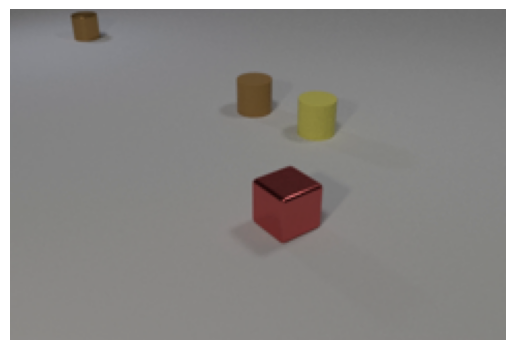

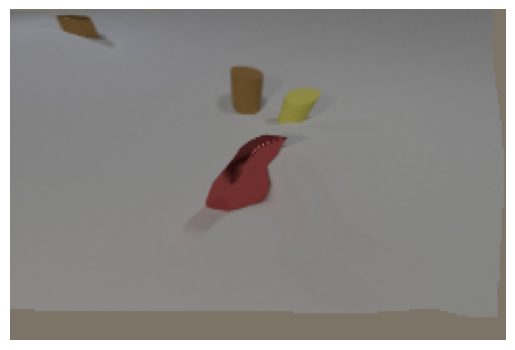

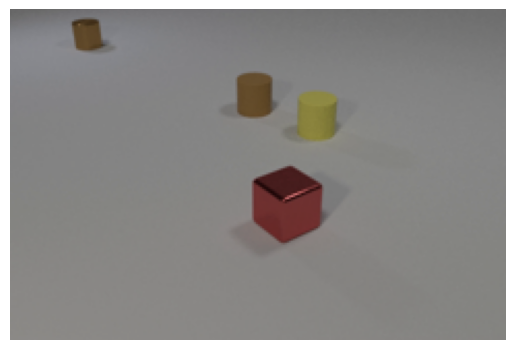

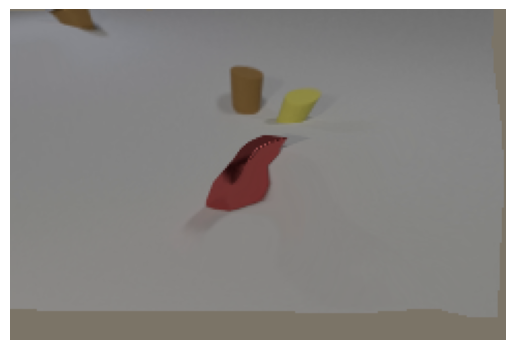

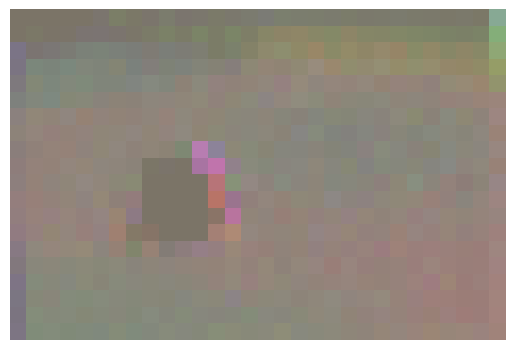

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


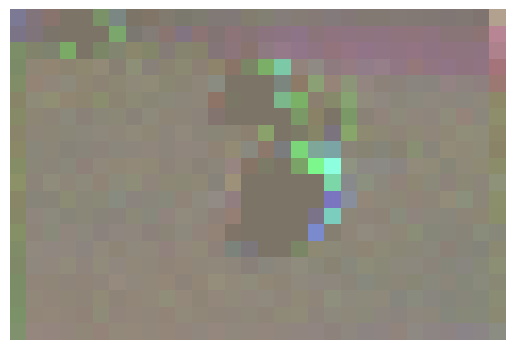

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


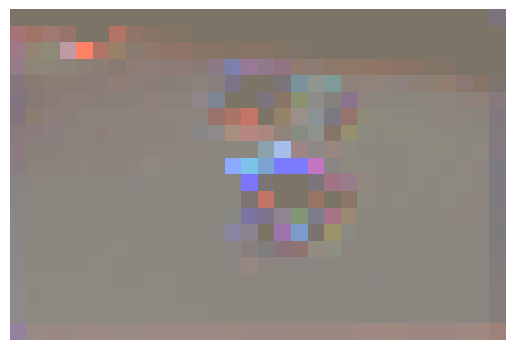

In [17]:

for batch in train_dataloader:
    MCJepa_model.reset_flows()
    frame_list, frame_list_aug, label = batch[0], batch[1], batch[2]
    img1 = frame_list[0].to(device)
    img2 = frame_list[1].to(device)
    img3 = frame_list_aug[0].to(device)
    X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext, Y1, Y2, X_tcrop,\
                                            X_tconcat = MCJepa_model(img1, img2, img3)

    loss = MCJepa_criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                    f_tnext_t, I_hat_t, I_hat_tnext, img1, img2,\
                     Y1, Y2, X_tcrop, X_tconcat, lm, mu, nu, lambda_a, lambda_b)
    print("Loss: ", loss.item())
#     flow_1 = f_t_tnext
    flow_2 = f_t_tnext
    print(f_t_tnext[0].shape)
    print((f_t_tnext[0] == 0).all())
    

    show_normalized_image(img1[0])
    plt.show()
    show_normalized_image(I_hat_t[0])
    plt.show()
    show_normalized_image(img2[0])
    plt.show()
    show_normalized_image(I_hat_tnext[0])
    plt.show()
#     print(Y1)
    show_normalized_image(X_tconcat[1][0:3])
    plt.show()
    show_normalized_image(X_tconcat[0][1:4])
    plt.show()
    show_normalized_image(X_tconcat[0][4:7])
    plt.show()
    
    break

### Downstream Task

In [18]:
for param in MCJepa_model.parameters():
    param.requires_grad = False

In [19]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=49):
        super().__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Up5 = up_conv(ch_in=img_ch,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=512, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=256, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=128, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=64, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(128,output_ch,kernel_size=1,stride=1,padding=0)
        self.softmax = nn.Softmax(dim=1)


    def forward(self,x):
        # encoding path
#         print(x.shape)
#         x1 = self.Conv1(x)

#         x2 = self.Maxpool(x1)
#         x2 = self.Conv2(x2)
        
#         x3 = self.Maxpool(x2)
#         x3 = self.Conv3(x3)

#         x4 = self.Maxpool(x3)
#         x4 = self.Conv4(x4)

#         x5 = self.Maxpool(x4)
#         x5 = self.Conv5(x5)

        # decoding + concat path
        x = self.Up5(x)
#         d5 = torch.cat((x4,d5),dim=1)
        
        x = self.Up_conv5(x)
        
        x = self.Up4(x)
#         d4 = torch.cat((x3,d4),dim=1)
        x = self.Up_conv4(x)
        
        x = self.Up3(x)
# #         d3 = torch.cat((x2,d3),dim=1)
        x = self.Up_conv3(x)

#         x = self.Up2(x)
# #         d2 = torch.cat((x1,d2),dim=1)
#         x = self.Up_conv2(x)

        x = self.Conv_1x1(x)

#         x =  self.softmax(x)
#         print(x.shape)
        return x

In [20]:
def downstream_criterion(mask_pred, mask):
  # jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49)

  # return jaccard(mask_pred, mask)
    loss = nn.CrossEntropyLoss()
    return loss(mask_pred, mask)

def soft_dice_loss(y_pred, y_true, epsilon=1e-6): 
    C = 49
    y_true=y_true.clone()
    y_true.unsqueeze_(1) # convert to Nx1xHxW
    one_hot = torch.cuda.FloatTensor(y_true.size(0), C, y_true.size(2), y_true.size(3)).zero_()
    one_hot.scatter_(1, y_true, 1) 
    
    y_pred = y_pred.permute(0, 2, 3, 1)
    y_true = one_hot.permute(0, 2, 3, 1)
    
    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1))
    numerator = 2. * torch.sum(y_pred * y_true, axes)
    denominator = torch.sum(torch.square(y_pred) + torch.square(y_true), axes)
    
    return 1 - torch.mean((numerator + epsilon) / (denominator + epsilon))

def focal_loss(pred, target, alpha = 2, gamma = 0.25):
    C = 49
    ce_loss = F.cross_entropy(pred, target, reduction='mean', weight=torch.ones(C).to(device))
    pt = torch.exp(-ce_loss)
    focal_loss = ((1 - pt) ** gamma * ce_loss).mean()
    return focal_loss



In [21]:
def train_fine_tune(downstream_model, JepaModel, epochs, dataloader, criterion, optimizer):
    downstream_model.train()

    train_losses = []

    best_loss = float("inf")
    best_model = downstream_model.state_dict()

    for _ in range(epochs):
        total_train_loss = 0.0
        total_train_correct = 0.0

        JepaModel.reset_flows()

        pbar = tqdm(dataloader, leave=False)

        for j, batch in enumerate(pbar):
          
            if j == 333:
                break
                
            frame_list, frame_list_aug, mask_list = batch[0], batch[1], batch[2] # TODO
            total_train_loss = 0.0
            

            for i in range(len(frame_list) - 1):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+1].to(device)
                img3 = frame_list_aug[i].to(device)
                mask_list = mask_list.type(torch.LongTensor).to(device)


                X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext, Y1, Y2, X_tcrop,\
                                          X_tconcat = JepaModel(img1, img2, img3)

#                 mask_pred = downstream_model(Y1)
                mask_pred = downstream_model(X_tconcat)
                loss = criterion(mask_pred, mask_list[:,i])

                total_train_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1)})

            if total_train_loss/(len(frame_list)-1) < best_loss:
                best_loss = total_train_loss/(len(frame_list)-1)
                best_model = downstream_model.state_dict()

                if j%25 == 0:
                    torch.save(best_model,"best_downstream_model.pth")
                    pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'Saved downstream model with loss': best_loss})
          
        pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1), 'Saved model at j': j})
        torch.save(downstream_model.state_dict(), "downstream_model.pth")
          
    torch.save(best_model,"best_downstream_model.pth")

In [ ]:
in_features_downstream = numLayers*out_features

downstream_model = U_Net(in_features_downstream).to(device)
downstream_optimizer = optim.Adam(downstream_model.parameters(), lr = 0.001)
train_fine_tune(downstream_model, MCJepa_model, 10, downstream_dataloader, focal_loss, downstream_optimizer)



 21%|██        | 70/334 [02:17<08:36,  1.96s/it, Per frame Loss=0.117]                                     

In [ ]:
PATH = "best_downstream_model.pth"
downstream_model = U_Net(in_features_downstream).to(device)
downstream_model.load_state_dict(torch.load(PATH))

In [ ]:
!pip install torchmetrics
import torchmetrics

In [ ]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49).to(device)

In [ ]:
def test(downstream_model, JepaModel, epochs, dataloader, criterion):
    

    train_losses = []

    best_loss = float("inf")
    best_model = downstream_model.state_dict()

    for _ in range(epochs):
        total_train_loss = 0.0

        JepaModel.reset_flows()

        pbar = tqdm(dataloader, leave=False)

        for j,batch in enumerate(pbar):
          
            frame_list, frame_list_aug, mask_list = batch[0], batch[1], batch[2] # TODO
            total_train_loss = 0.0
            

            for i in range(len(frame_list) - 1):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+1].to(device)
                img3 = frame_list_aug[i].to(device)
                mask_list = mask_list.type(torch.LongTensor).to(device)


                X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext, Y1, Y2, X_tcrop,\
                                          X_tconcat = JepaModel(img1, img2, img3)
                
#                 print(Y1.shape)
                mask_pred = downstream_model(X_tconcat)
#               
                if i == 20:
                    print(mask_pred.shape, mask_list[:,i].shape)
                    print(mask_list[:,i][0])

                    print(jaccard(mask_pred, mask_list[:,i]))
                    print((torch.argmax(mask_pred[0], dim=0) == 0).all())
                    plt.imshow(mask_list[0][i].cpu())
                    plt.show()
                    plt.imshow(torch.argmax(mask_pred[0].cpu(), dim=0))
                    plt.show()
                loss = criterion(mask_pred, mask_list[:,i])
                total_train_loss += loss.item()

            pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1)})

In [ ]:
test(downstream_model, MCJepa_model, 1, val_dataloader, downstream_criterion)

In [ ]:
def real_test(downstream_model, JepaModel, epochs, dataloader, criterion, optimizer):
    

    train_losses = []

    best_loss = float("inf")
    best_model = downstream_model.state_dict()

    for _ in range(epochs):
        total_train_loss = 0.0

        JepaModel.reset_flows()

        pbar = tqdm(dataloader, leave=False)

        for j,batch in enumerate(pbar):
          
            frame_list, frame_list_aug, mask_list = batch[0], batch[1], batch[2] # TODO
            total_train_loss = 0.0
            X_tconcat = None
            I_hat_t = None
            I_hat_tnext = None
            I_hat_t = None
            
            for i in range(11):
                img1 = frame_list[i].to(device)
                img2 = frame_list[i+1].to(device)
                img3 = frame_list_aug[i].to(device)
                mask_list = mask_list.type(torch.LongTensor).to(device)


                X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext, Y1, Y2, X_tcrop,\
                                          X_tconcat = JepaModel(img1, img2, img3)
                
            for i in range(11):
                X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext,\
                f_tnext_t, I_hat_t, I_hat_tnext, Y1, Y2, X_tcrop,\
                                          X_tconcat = JepaModel(I_hat_t, I_hat_tnext, I_hat_t)
                
            mask_pred = downstream_model(X_tconcat)
  
                
            
            print(mask_pred.shape, mask_list[:,21].shape)
            print(mask_list[:,21][0])

            print(jaccard(mask_pred, mask_list[:,21]))
            print((torch.argmax(mask_pred[0], dim=0) == 0).all())
            plt.imshow(mask_list[0][21].cpu())
            plt.show()
            plt.imshow(torch.argmax(mask_pred[0].cpu(), dim=0))
            plt.show()
            loss = criterion(mask_pred, mask_list[:,21])
            total_train_loss += loss.item()

            pbar.set_postfix({'Per frame Loss': total_train_loss/(len(frame_list)-1)})

In [ ]:
real_test(downstream_model, MCJepa_model, 1, val_dataloader, downstream_criterion, downstream_optimizer)